<a href="https://colab.research.google.com/github/DiaaEssam/Digit_Recognizer_with_API/blob/master/ANN_from_scratch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
tf.test.gpu_device_name()
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Loading MNIST Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


# Applying One Hot Encodeing for labels

In [ ]:
"""num_classes=len(np.unique(y_train))
y_train=np.array([np.insert(np.zeros(num_classes-1),i,1) for i in y_train]).astype(int) another way implemented by me"""

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train=enc.fit_transform(y_train.reshape(y_train.shape[0],1)).toarray().astype(int)
y_test=enc.transform(y_test.reshape(y_test.shape[0],1)).toarray().astype(int)

print(y_train.shape)
print(y_train[0])
print(y_test.shape)
print(y_test[0])

(60000, 10)
[0 0 0 0 0 1 0 0 0 0]
(10000, 10)
[0 0 0 0 0 0 0 1 0 0]


# Visualizing some of The Data

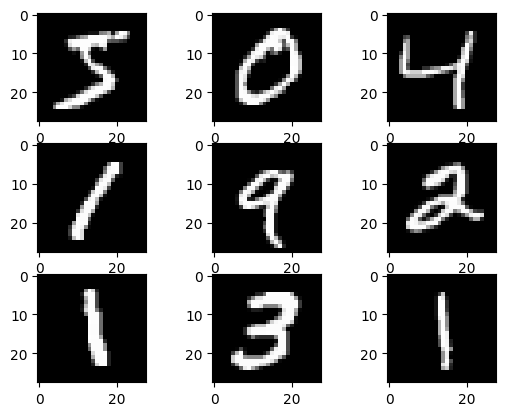

In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

# Transforming The Dimensions

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train=X_train.reshape(X_train.shape[0],-1)
X_test=X_test.reshape(X_test.shape[0],-1)
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 784)
Y_train: (60000, 10)
X_test:  (10000, 784)
Y_test:  (10000, 10)


# Standardizing The Data

In [ ]:
def normalize(X):
  return X/255.0 # we need epsilon for feature (pixel) that has zero variance

In [ ]:
X_train=normalize(X_train)
X_test=normalize(X_test)

# Shuffle Function

In [ ]:
def Shuffle(X,y):
  # Storing indeces of data
  indices = np.arange(X.shape[0])
  # Shuffling the indeces
  np.random.shuffle(indices)
  # update the data and target with the new shuffled indeces
  X = X[indices]
  y = y[indices]
  return X,y

In [ ]:
X_train,y_train=Shuffle(X_train,y_train)

# Accuracy Function

In [ ]:
def Accuracy(y_pred,y_test):
    # argmax returns the index of the maximum element in a numpy array
    Acc=np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1),axis=0) * 100
    return round(Acc,1)

# Error Function

In [ ]:
def Error(y_pred,y_test):
  return  (1/(2*y_test.shape[0])) * np.sum((y_pred-y_test)**2)

# Sigmoid Function

In [ ]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

# Softmax Function

In [ ]:
def softmax(Z):
  # Divides the exponent of Z on the sum of each row vector
  Z=np.exp(Z)/np.sum(np.exp(Z),axis=1,keepdims=True)
  return Z

# Relu Derivative

In [ ]:
def der_Relu(A):
  A[A<0]=0
  A[A>=0]=1
  return A

# Layer_Size Function

In [ ]:
def layer_sizes(X,y,size_of_layers):
    # Inserts the size of the input layer at the start of the array
    size_of_layers.insert(0,X.shape[1])
    return size_of_layers

In [ ]:
L_sizes=layer_sizes(X_train,y_train,[20,10])

# Printing shapes

In [ ]:
def Print_shapes(container,param):
  if param:
    # Prints each W and each b between the layers
    print('L',['layer '+str(i) for i in range(len(container["W"])+1)])
    print('W',[container['W'][i].shape for i in range(len(container["W"]))])
    print('b',[container['b'][i].shape for i in range(len(container["W"]))])
  else:
    # Prints each dW and each db between the layers
    print('L',['layer '+str(i) for i in range(len(container["dW"])+1)])
    print('dW',[container['dW'][i].shape for i in range(len(container["dW"]))])
    print('db',[container['db'][i].shape for i in range(len(container["dW"]))])

#Initializing the model's parameters

In [ ]:
def initialize_parameters(L_sizes):
    W=[]
    b=[]
    # Inialize W to be size of next layer by size of current layer, Inialize b to be size of next layer by 1
    for i in range(len(L_sizes)-1):
      W.append(np.random.randn(L_sizes[i+1],L_sizes[i]))
      b.append(np.zeros((L_sizes[i+1],1)))

    parameters = {
        'W':W,
        'b':b
    }

    Print_shapes(parameters,True)

    return parameters

# Forward propagation

In [ ]:
def forward_propagation(X, parameters,Tanh,Relu):

    Z=[]
    A=[]

    for i in range(len(parameters["W"])):
                                                                  # if we are at the first layer then we use X, O.W. we use A[L-1]
      Z.append(np.dot(parameters["W"][i],X.T) + parameters["b"][i]) if i==0 else Z.append(np.dot(parameters["W"][i],A[i-1]) + parameters["b"][i])
      if Tanh:
        A.append(sigmoid(Z[i])) if i==len(parameters["W"])-1 else A.append(np.tanh(Z[i]))
      if Relu:
        A.append(sigmoid(Z[i])) if i==len(parameters["W"])-1 else A.append(np.maximum(0,Z[i]))
      if (not Tanh) and (not Relu):                                                                                       # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
        A.append(sigmoid(Z[i]))


    cache = {
        'Z':Z,
        'A':A
    }


    return cache

# Backward Propagation

In [ ]:
def backward_propagation(parameters, cache, X, y,print_once,Tanh,Relu):

    dZ=[]
    dW=[]
    db=[]
    j=0

    # we will move backward so I reversed the direction of the iterator by giving (no. layer-1, -1 which will make the iterator stop at 0,-1 which is responsible for reversing the direction)
    for i in range(len(parameters["W"])-1,-1,-1):
    # if last layer then compute dL/dZ = A[L] - y
      if i==len(parameters["W"])-1:
        dZ.append(cache['A'][i].T-y)
    # else compute dL/dZ[L] = W[L+1] * dL/dZ[L+1] * dA/dZ[L], where dA/dZ[L] = A[L] * (1 - A[L])
      else:
        if Tanh:                                                                      # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
          dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1].T) * (1 - cache["A"][i]**2)) if parameters["W"][i+1].T.shape[1]==dZ[j-1].T.shape[0] else dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1]) * (1 - cache["A"][i]**2))
        if Relu:
          dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1].T) * der_Relu(cache["A"][i])) if parameters["W"][i+1].T.shape[1]==dZ[j-1].T.shape[0] else dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1]) * der_Relu(cache["A"][i]))
        if (not Tanh) and (not Relu):                                                                                       # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
          dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1].T) * (cache["A"][i] * (1 - cache["A"][i]))) if parameters["W"][i+1].T.shape[1]==dZ[j-1].T.shape[0] else dZ.append(np.dot(parameters["W"][i+1].T,dZ[j-1]) * (cache["A"][i] * (1 - cache["A"][i])))
    # if first layer then compute dL/dW[L] = dL/dZ[L] * X
      if i==0:
        dW.append(1/y.shape[0] * np.dot(dZ[j],X))
    # else compute dL/dW[L] = dL/dZ[L] * A[L-1]
      else:                                                         # we check here if we can use dot product properly or do we need to transpose one of the arrays so the dot product could work
        dW.append(1/y.shape[0] * np.dot(dZ[j].T,cache['A'][i-1].T))  if dZ[j].T.shape[1]==cache['A'][i-1].T.shape[0] else  dW.append(1/y.shape[0] * np.dot(dZ[j],cache['A'][i-1].T))
                                                                    # we make sure that the size of db be the same as b not (60000,1)
      db.append(1/y.shape[0] * np.sum(dZ[j],axis=1,keepdims=True)) if np.sum(dZ[j],axis=1,keepdims=True).shape[0]!=X.shape[0] else db.append(1/y.shape[0] * np.sum(dZ[j].T,axis=1,keepdims=True))

      j+=1

    grads = {
        'dW':dW,
        'db':db
    }

    Print_shapes(grads,False) if print_once else ""

    return grads

# Initializing RMS parameters

In [ ]:
def Initialize_RMS(beta,epsilon,Vdw,vdb):
  return beta,epsilon,Vdw,vdb

#Initializing Adam parameters

In [ ]:
def Initialize_Adam(beta1,beta2,epsilon,Vdw,Sdw,Vdb,Sdb):
  return beta1,beta2,epsilon,Vdw,Sdw,Vdb,Sdb

# RMS Function

In [ ]:
def RMS(beta,epsilon,t,W,b,dw,db,VdW,Vdb,LR):
  """
  -The RMSProp (Root Mean Square Propagation)
  -The RMSProp optimizer works by maintaining a moving average of the squared gradient for each weight
  -The RMSProp optimizer uses a decay rate/beta hyperparameter to control the weighting of past and current gradients.
  -This decay rate determines how much weight is given to the most recent gradient compared to the historical gradients.
  -A larger decay rate means that the moving average will be more heavily influenced by the historical gradients,
  -while a smaller decay rate means that the moving average will be more influenced by the most recent gradient.
  """

  """
  -Vdw is the moving average of the squared gradients of the weights, and Vdb is the moving average of the squared gradients of the biases.
  -These moving averages are used to adjust the learning rate during training, with the goal of improving the convergence of the optimization algorithm.
  """

  """
  -The letter "V" in Vdw and Vdb stands for "variance". In the context of the RMSProp optimizer, Vdw and Vdb represent the variance of the gradients of the weights and biases, respectively.
  -The use of variance in the RMSProp optimizer is based on the intuition that the variance of the gradients can provide information about the scale of the gradients.
  -If the variance of the gradients is high, it suggests that the gradients are large and the learning rate should be reduced to prevent overshooting the minimum. Conversely,
  -if the variance of the gradients is low, it suggests that the gradients are small and the learning rate can be increased to speed up convergence.
  """
  VdW = ((beta * VdW) + ((1 - beta) * (dw**2))) / (1 - beta**t + epsilon)
  Vdb = ((beta * Vdb) + ((1 - beta) * (db**2))) / (1 - beta**t + epsilon)
  W = W - (LR * (dw/(np.sqrt(VdW) + epsilon)))
  b = b - (LR * (db/(np.sqrt(Vdb) + epsilon)))
  return W,b


#Adam Functon

In [ ]:
def Adam(beta1,beta2,t,epsilon,W,b,dw,db,VdW,SdW,Vdb,Sdb,eta):
  """
  -The Adam (Adaptive Moment Estimation) optimizer is a popular optimization algorithm used in deep learning.
  -It is an adaptive learning rate optimization algorithm that combines the benefits of two other optimization algorithms, RMSProp and momentum.
  """

  """
  -The Adam optimizer works by maintaining a moving average of the gradients and the squared gradients of the weights
  -VdW = beta1 * VdW + (1 - beta1) * dL/dw
  -SdW = beta2 * SdW + (1 - beta2) * (dL/dw)^2
  -VdW_corrected = VdW_corrected / (1 - beta1^t)
  -SdW_corrected = SdW_corrected / (1 - beta2^t)
  -w = w - alpha * VdW_corrected / (sqrt(SdW_corrected) + epsilon)
  -the same for b
  """

  """
  -beta1 and beta2 are hyperparameters
  Set β1=0, means that ADAM behaves exactly as RMSprop optimizer
  Set β2=0, means that ADAM behaves exactly as Momentum optimizer
  """
  VdW= (beta1 * VdW) + ((1 - beta1) * dw)    # Momentum
  Vdb= (beta1 * Vdb) + ((1 - beta1) * db)    # Momentum
  SdW= (beta2 * SdW) + ((1 - beta2) * dw**2) # RMS, represents variance that will be square rooted soon
  Sdb= (beta2 * Sdb) + ((1 - beta2) * db**2) # RMS, represents variance that will be square rooted soon
  """
  -The bias correction step helps to ensure that the moving averages are unbiased estimates of the true first and second moments of the gradients.
  -Without the bias correction step, the moving averages would be biased towards zero, which could lead to slower convergence or suboptimal performance.
  """
  VdW_corrected= VdW/(1 - beta1**t + epsilon) # bias correction
  Vdb_corrected= Vdb/(1 - beta1**t + epsilon) # bias correction
  SdW_corrected= SdW/(1 - beta2**t + epsilon) # bias correction
  Sdb_corrected= Sdb/(1 - beta2**t + epsilon) # bias correction

  W = W - eta * (VdW_corrected/np.sqrt(SdW_corrected + epsilon)) # SdW_corrected is standard deviation here
  b = b - eta * (Vdb_corrected/np.sqrt(Sdb_corrected + epsilon)) # SdW_corrected is standard deviation here
  return W,b

# Update Parameters

In [ ]:
def update_parameters(parameters, grads, LR = 1.2,beta=0,beta1=0,beta2=0,j=0,epsilon=0,VdW=0,SdW=0,Vdb=0,Sdb=0,rms=False,adam=False):

    for i in range(len(parameters["W"])):
      if rms:
          parameters["W"][i],parameters["b"][i]=RMS(beta,epsilon,j,parameters["W"][i],parameters["b"][i],grads['dW'][len(parameters["W"])-1-i],grads['db'][len(parameters["W"])-1-i],VdW[len(parameters["W"])-1-i],Vdb[len(parameters["W"])-1-i],LR)
      if adam:
          parameters["W"][i],parameters["b"][i]=Adam(beta1,beta2,j,epsilon,parameters["W"][i],parameters["b"][i],grads['dW'][len(parameters["W"])-1-i],grads['db'][len(parameters["W"])-1-i],VdW[len(parameters["W"])-1-i],SdW[len(parameters["W"])-1-i],Vdb[len(parameters["W"])-1-i],Sdb[len(parameters["W"])-1-i],LR)
      else:

        # last value stored in dW and db are the gradients for the first W and b, that's why we are using parameters["W"])-1-i
          parameters["W"][i]=parameters["W"][i]-LR * grads['dW'][len(parameters["W"])-1-i]
          parameters["b"][i]=parameters["b"][i]-LR * grads['db'][len(parameters["W"])-1-i]

    return parameters

# Train_model Function

In [ ]:
def train_model(X,y,batch_size,parameters,print_once,Tanh,Relu):
    # applying forward propagation
      cache=forward_propagation(X, parameters,Tanh,Relu)
    # computing Error/Cost
      cost=Error(cache['A'][-1].T,y)
    # Computing gradients
      grads=backward_propagation(parameters,cache,X,y,print_once,Tanh,Relu)
      return cost,grads

# Test_model Function

In [ ]:
# function to test on each model
def test_model(parameters,X_test,y_test,Tanh=False,Relu=False):
    y_pred=np.zeros((X_test.shape[0],y_test.shape[1]))
    # calling forward propagation to make predictions
    cache=forward_propagation(X_test,parameters,Tanh,Relu)
    # using softmax on y_pred
    y_pred=softmax(cache['A'][-1].T)
    return Accuracy(y_pred,y_test)

# Neural Network

In [ ]:
def NN(X, y,num_of_layers,size_of_layers,epochs,LR,Tanh=False,Relu=False,batch_size=X_train.shape[0],rms=False,adam=False):
    L_sizes=layer_sizes(X,y,size_of_layers)
    parameters=initialize_parameters(L_sizes)

    print_once=True
    for j in range(epochs):

      num_batches=int(X.shape[0]/batch_size)
      for i in range(num_batches):
          if rms:
              cost,grads=train_model(X[i*batch_size:batch_size*(i+1)],y[i*batch_size:batch_size*(i+1)],batch_size,parameters,print_once,Tanh,Relu)
              print_once=False
              beta,epsilon,VdW,Vdb = Initialize_RMS(0.9,10e-16,[0] * num_of_layers,[0] * num_of_layers)
              parameters=update_parameters(parameters,grads,LR=LR,beta=beta,j=j,epsilon=epsilon,VdW=VdW,Vdb=Vdb,rms=True)

          if adam:
              cost,grads=train_model(X[i*batch_size:batch_size*(i+1)],y[i*batch_size:batch_size*(i+1)],batch_size,parameters,print_once,Tanh,Relu)
              print_once=False
              beta1,beta2,epsilon,VdW,SdW,Vdb,Sdb = Initialize_Adam(0.9,0.999,10e-16,[0] * num_of_layers,[0] * num_of_layers,[0] * num_of_layers,[0] * num_of_layers)
              parameters=update_parameters(parameters,grads,LR=LR,beta1=beta1,beta2=beta2,j=j,epsilon=epsilon,VdW=VdW,SdW=SdW,Vdb=Vdb,Sdb=Sdb,adam=True)

          else:

              if i != num_batches-1:
                cost,grads=train_model(X[i*batch_size:batch_size*(i+1)],y[i*batch_size:batch_size*(i+1)],batch_size,parameters,print_once,Tanh,Relu)
                print_once=False
              # Updating the parameters
                parameters=update_parameters(parameters,grads,LR=LR)
              else:
                cost,grads=train_model(X[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],y[i*batch_size:batch_size*(i+1) + X.shape[0] % batch_size],batch_size,parameters,print_once,Tanh,Relu)
                print_once=False
              # Updating the parameters
                parameters=update_parameters(parameters,grads,LR=LR)

      if j % 50 == 0:
            print ("Cost after iteration %i: %f" %(j, cost))

    return parameters

# 1- Build NN with only 2 layers => 1 hidden layer and 1 output layer

In [ ]:
parameters=NN(X_train, y_train,2,[20,10],150,1,batch_size=64)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 0.123601
Cost after iteration 50: 0.035927
Cost after iteration 100: 0.032713


In [ ]:
print(test_model(parameters,X_test,y_test))

94.1


In [ ]:
parameters=NN(X_train, y_train,2,[20,10],45,0.01,batch_size=512,rms=True)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 0.550745


In [ ]:
print(test_model(parameters,X_test,y_test))

92.0


## 2- Build NN with 3 layers=> 2 hidden layers Where no. of neurons in first layer < no. of neurons in second layer and 1 output layer

In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],45,1,batch_size=128)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.128769


In [ ]:
print(test_model(parameters,X_test,y_test))

94.8


In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],70,0.001,batch_size=512,rms=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.960676
Cost after iteration 50: 0.044095


In [ ]:
print(test_model(parameters,X_test,y_test))

94.0


In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],15,0.0000000001,batch_size=64,adam=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.120897


In [ ]:
print(test_model(parameters,X_test,y_test))

89.4


## 3- Build NN with 3 layers=> 2 hidden layers Where no. of neurons in first layer > no. of neurons in second layer

In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],40,2,batch_size=128)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 0.108657


In [ ]:
print(test_model(parameters,X_test,y_test))

94.7


In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],60,0.001,batch_size=512,rms=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 1.000557
Cost after iteration 50: 0.044402


In [ ]:
print(test_model(parameters,X_test,y_test))

94.1


In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],15,0.000000001,batch_size=128,adam=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 0.104835


In [ ]:
print(test_model(parameters,X_test,y_test))

88.8


# 1- Build NN_Relu with only 2 layers => 1 hidden layer and 1 output layer

In [ ]:
parameters=NN(X_train, y_train,2,[20,10],45,0.1,Relu=True,batch_size=128)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 0.261365


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

82.5


In [ ]:
parameters=NN(X_train, y_train,2,[20,10],150,0.0001,Relu=True,batch_size=512,rms=True)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 2.188263
Cost after iteration 50: 0.145059
Cost after iteration 100: 0.114676


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

90.3


In [ ]:
parameters=NN(X_train, y_train,2,[20,10],50,0.000000001,Relu=True,batch_size=64,adam=True)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 0.241703


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

82.8


## 2- Build NN_Relu with 3 layers=> 2 hidden layers Where no. of neurons in first layer < no. of neurons in second layer and 1 output layer

In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],200,0.01,Relu=True,batch_size=256)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.378769
Cost after iteration 50: 0.123022
Cost after iteration 100: 0.128800
Cost after iteration 150: 0.122798


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

86.5


In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],150,0.0001,Relu=True,batch_size=256,rms=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.882353
Cost after iteration 50: 0.162008
Cost after iteration 100: 0.134591


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

87.4


In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],50,0.000000001,Relu=True,batch_size=32,adam=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.568830
Cost after iteration 50: 0.345168


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

44.1


## 3- Build NN_Relu with 3 layers=> 2 hidden layers Where no. of neurons in first layer > no. of neurons in second layer

In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],200,0.001,Relu=True,batch_size=512)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 0.850199
Cost after iteration 50: 0.250541
Cost after iteration 100: 0.192944
Cost after iteration 150: 0.165675


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

81.2


In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],200,0.0001,Relu=True,batch_size=256,rms=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 0.966442
Cost after iteration 50: 0.156761
Cost after iteration 100: 0.138714
Cost after iteration 150: 0.151520


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

82.0


In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],50,0.000000001,Relu=True,batch_size=32,adam=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 2.906250


In [ ]:
print(test_model(parameters,X_test,y_test,Relu=True))

9.8


# 1- Build NN_Tanh with only 2 layers => 1 hidden layer and 1 output layer

In [ ]:
parameters=NN(X_train, y_train,2,[20,10],200,0.5,Tanh=True,batch_size=256)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 0.217704
Cost after iteration 50: 0.064367
Cost after iteration 100: 0.058978
Cost after iteration 150: 0.055586


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

92.4


In [ ]:
parameters=NN(X_train, y_train,2,[20,10],200,0.0001,Tanh=True,batch_size=256,rms=True)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 1.945170
Cost after iteration 50: 0.122017
Cost after iteration 100: 0.086768
Cost after iteration 150: 0.081008


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

91.2


In [ ]:
parameters=NN(X_train, y_train,2,[20,10],50,0.000000001,Tanh=True,batch_size=32,adam=True)

L ['layer 0', 'layer 1', 'layer 2']
W [(20, 784), (10, 20)]
b [(20, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2']
dW [(10, 20), (20, 784)]
db [(10, 1), (20, 1)]
Cost after iteration 0: 0.114071


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

86.4


## 2- Build NN_Tanh with 3 layers=> 2 hidden layers Where no. of neurons in first layer < no. of neurons in second layer and 1 output layer

In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],100,0.5,Tanh=True,batch_size=256)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.243057
Cost after iteration 50: 0.060044


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

91.1


In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],200,0.0001,Tanh=True,batch_size=256,rms=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 2.107043
Cost after iteration 50: 0.135050
Cost after iteration 100: 0.087318
Cost after iteration 150: 0.082539


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

91.0


In [ ]:
parameters=NN(X_train, y_train,3,[20,40,10],50,0.000000001,Tanh=True,batch_size=32,adam=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(20, 784), (40, 20), (10, 40)]
b [(20, 1), (40, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 40), (40, 20), (20, 784)]
db [(10, 1), (40, 1), (20, 1)]
Cost after iteration 0: 0.141097


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

76.1


## 3- Build NN_Tanh with 3 layers=> 2 hidden layers Where no. of neurons in first layer > no. of neurons in second layer

In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],100,0.5,Tanh=True,batch_size=256)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 0.261390
Cost after iteration 50: 0.055958


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

92.5


In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],140,0.0001,Tanh=True,batch_size=256,rms=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 2.212261
Cost after iteration 50: 0.114223
Cost after iteration 100: 0.083871


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

91.3


In [ ]:
parameters=NN(X_train, y_train,3,[30,15,10],50,0.000000001,Tanh=True,batch_size=32,adam=True)

L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
W [(30, 784), (15, 30), (10, 15)]
b [(30, 1), (15, 1), (10, 1)]
L ['layer 0', 'layer 1', 'layer 2', 'layer 3']
dW [(10, 15), (15, 30), (30, 784)]
db [(10, 1), (15, 1), (30, 1)]
Cost after iteration 0: 0.136820


In [ ]:
print(test_model(parameters,X_test,y_test,Tanh=True))

86.1
